# Training a neural network to predict total density using form factor
This notebook shows how a neural network can be trained to predict total density profiles from form factors.  
It contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html).  
2) Preprocess data for the machine learning pipeline.  
3) Train and evaluate the performance of the neural network.  

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):  
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.  
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.  

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "3"  # Set TensorFlow verbosity to lowest (only print errors)
)

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath = "./Databank/"  # this is the local path for the cloned Databank
sys.path.insert(1, databankPath + "/Scripts/BuildDatabank/")
from databankLibrary import *
from new_functions import *

systems = initialize_databank(databankPath)

Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


### Inclusion criteria
Systems are excluded if either of these occur:   
- There are warnings about:  
    - periodic boundary condition (PBC)  
    - or x-normal orientation  
- There is too little water in the simulation

In [4]:
# Some systems have periodic boundary condition (PBC) warnings and should be excluded from the analysis
PBC_warning_count = 0
xnormal_warning_count = 0
for system in systems:
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
        if (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            xnormal_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
print("Number of systems with PBC warnings:", PBC_warning_count)
print("Number of systems with xnormal warnings:", xnormal_warning_count)

Number of systems with PBC warnings: 15
Number of systems with xnormal warnings: 3


In [5]:
# Exclude based on water/lipid ratio
water_to_lipid_ratio_threshold = 20
little_water_systems = 0
for system in systems: 
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except Exception:
        continue
    #print(water_to_lipid_ratio)
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        little_water_systems += 1
print("Number of systems with too little water:", little_water_systems)

Number of systems with too little water: 34


In [6]:
# POPC (This is currently not used for exclusion)
POPC_above_1_counter = 0
for system in systems:
    POPC = getPOPC(system, databankPath)
    if POPC is not None: 
        #print(POPC)
        pass
    if POPC is None or POPC > 1:
        POPC_above_1_counter += 1
print("POPC_above_1_counter:", POPC_above_1_counter)

POPC_above_1_counter: 486


Now we extract the form factor (ff) and total density (td) data of each simulation from the "system" variables.  
Each form factor has a shape of (1000), but the total densities have dimensions that vary.  
The total densities are split into separate lists td_x and td_y.  

In [7]:
system_ids = []
all_ff = []
all_td_x = []
all_td_y = []
td_x_lengths = []
td_y_lengths = []

# Complete data should have form factors of length 1000
required_form_factor_dimension = 1000

# Load form factors and total densities
for system in systems:

    # Exclude on warnings: 
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            continue  # Skip system with PBC warnings
        elif (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            continue  # Skip system with x-normal orientation warnings
    
    # Exclude on water to lipid ratio
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except Exception:
        continue
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        continue

    # Load form factor and total density for the systems that pass the inclusion criteria
    FFsim, TDsim = getFormFactorAndTotalDensityPair(system, databankPath)
    if (
        isinstance(FFsim, list)
        and isinstance(TDsim, list)
        and len(FFsim) == required_form_factor_dimension
    ):
        system_ids.append(system["ID"])  # Add system ID to the list

        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff)  # Add form factor to the list

        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x)  # Add total density x values to the list
        all_td_y.append(td_y)  # Add total density y values to the list
        td_x_lengths.append(len(td_x))
        td_y_lengths.append(len(td_y))

assert (
    len(system_ids) == len(all_ff) == len(all_td_x) == len(all_td_y)
)  # Be sure that there are as many form factors as total densitiess
assert (
    td_x_lengths == td_y_lengths
)  # Be sure that dimensions of x and y values match for every simulation
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 741


In [8]:
# Sort all lists by system id
system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths = [
    list(elem)
    for elem in zip(
        *sorted(zip(system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths))
    )
]

### Take the time to get to know what the data looks like

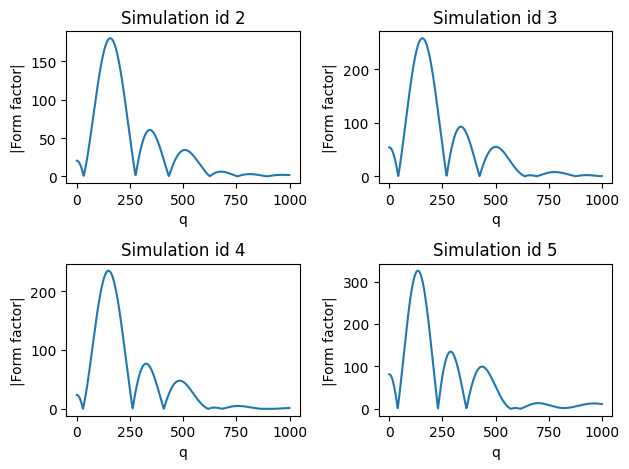

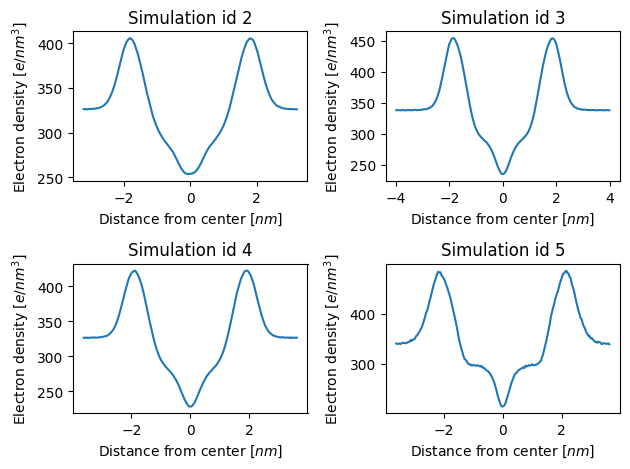

In [9]:
# Visualize form factors and total density profiles
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting = 0

if "start_of_plotting" not in globals():
    start_of_plotting = 0

# Plot four density profiles
ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Form factors of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Density profiles of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
td_axs = td_axs.flatten()

x_axis_label_ff = "q"
y_axis_label_ff = "|Form factor|"
x_axis_label_td = "Distance from center [" + r"$nm$" + "]"
y_axis_label_td = "Electron density [" + r"$e/nm^3$" + "]"


plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if plot_counter >= start_of_plotting:
        ff_axs[plot_index].plot(ff_vector)
        ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        ff_axs[plot_index].set_xlabel(x_axis_label_ff)
        ff_axs[plot_index].set_ylabel(y_axis_label_ff)
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting = plot_counter + 1
            break
ff_fig.tight_layout()
td_fig.tight_layout()

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range of the total densities varies between simulations.
- Most density profiles have flat "shoulders", but not all: Some seem to be truncated in the x direction.

In [10]:
# Find the systems with narrow x dimension
narrow_limit = 2.9  # Many systems whose total density profiles are narrower than [-2.9, 2.9] seem to have nonsmooth periodic conditions that are not marked by errors
narrow_td_system_ids = []
for system_id, x_vector, y_vector, ff_vector in zip(
    system_ids, all_td_x, all_td_y, all_ff
):
    if max(x_vector) < narrow_limit:
        narrow_td_system_ids.append(system_id)
print("IDs of systems with narrow total densities:", narrow_td_system_ids)
print("Number of systems with narrow total densities:", len(narrow_td_system_ids))

IDs of systems with narrow total densities: [277, 344, 379, 519]
Number of systems with narrow total densities: 4


In [11]:
# Print the water/lipid ratio of the narrow systems
narrow_water_to_lipid_ratios = []
for system in systems: 
    if system["ID"] in narrow_td_system_ids: 
        try:
            water_to_lipid_ratio = getHydrationLevel(system)
        except Exception:
            continue
        narrow_water_to_lipid_ratios.append(int(water_to_lipid_ratio))
print(narrow_water_to_lipid_ratios)
print(len(narrow_water_to_lipid_ratios))

[24, 28, 25, 28]
4


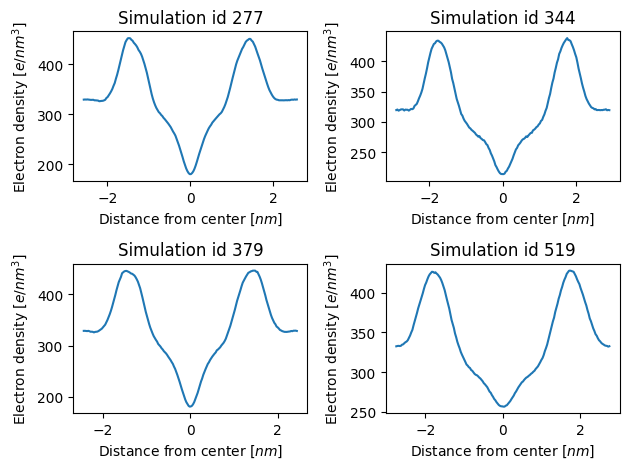

In [12]:
# Visualize the narrow systems
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting_narrow_systems = 0

if "start_of_plotting_narrow_systems" not in globals():
    start_of_plotting_narrow_systems = 0

# Plot four density profiles
# ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
# # plt.suptitle("Form factors of simulations " + str(start_of_plotting_narrow_systems) + " to " + str(start_of_plotting_narrow_systems+3))
# ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Density profiles of simulations " + str(start_of_plotting_narrow_systems) + " to " + str(start_of_plotting_narrow_systems+3))
td_axs = td_axs.flatten()

x_axis_label_ff = "q"
y_axis_label_ff = "|Form factor|"
x_axis_label_td = "Distance from center [" + r"$nm$" + "]"
y_axis_label_td = "Electron density [" + r"$e/nm^3$" + "]"


plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if system_id in narrow_td_system_ids and plot_counter >= start_of_plotting_narrow_systems:
        # ff_axs[plot_index].plot(ff_vector)
        # ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        # ff_axs[plot_index].set_xlabel(x_axis_label_ff)
        # ff_axs[plot_index].set_ylabel(y_axis_label_ff)
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting_narrow_systems = plot_counter + 1
            break
# ff_fig.tight_layout()
td_fig.tight_layout()

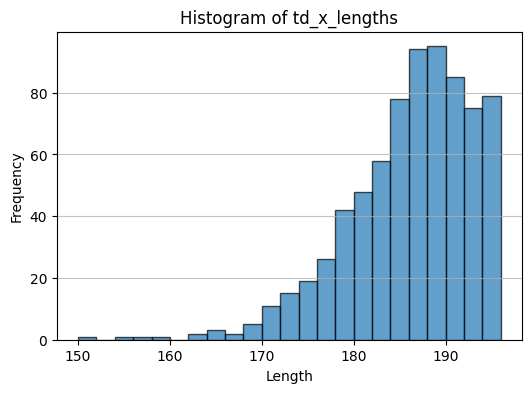

Every td_x length present in the dataset: {150, 154, 156, 158, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196}
(The lenght of td_y matches td_x for each simulation)


In [13]:
# Visualize that the length of the total density data varies between simulations
plt.figure(figsize=(6, 4))
plt.hist(td_x_lengths, bins=23, edgecolor="black", alpha=0.7)
plt.title("Histogram of td_x_lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()
print("Every td_x length present in the dataset:", set(td_x_lengths))
print("(The lenght of td_y matches td_x for each simulation)")

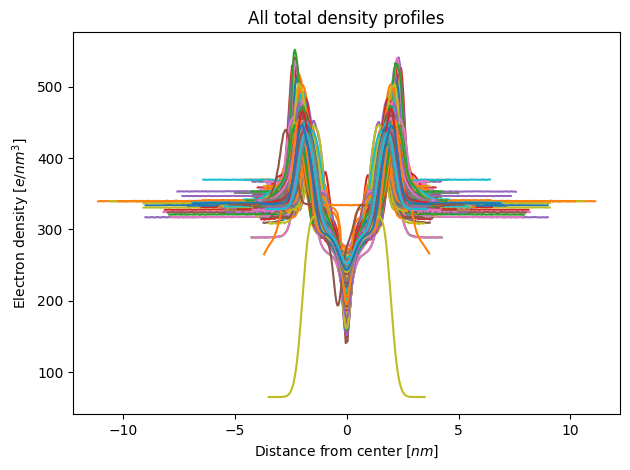

In [14]:
# Plot all total density profiles together
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, all_td_x, all_td_y, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles")
plt.tight_layout()
plt.show()

### Homogenize the data format of the total densities
The histogram of td_x_lengths shows that the different simulations have different numbers of observed values.  
Furthermore, the plot of total densities shows that some total densities have long flat tails while others are seemingly truncated in the x direction.  
Since the model fitting requires data with a uniform format, a preprocessing process is needed to define a common x grid for the density profiles.  

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments.  
Aother option is to only include the widest experiments, but this also leads to a large loss of data.  
A compromise could be to trim the shoulders of the widest simulations, and extrapolate the narrowest simulations a bit. 

In the following code block, an x interval centered around zero is chosen.  
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window.  
This makes sure that all experiments have either actual measurements or extrapolated values across the entire x interval.  

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval.  
This brings all the data on the same format. 

In [15]:
# Define start and end of the common x interval
# Systems that are more narrow than this will be extrapolated in the x direction (not ideal), and wider systems truncated (not ideal but not less critical)
x_interval_start = -narrow_limit # This could be changed to something else
x_interval_end = narrow_limit
desired_length_of_padded_data = 400

padded_td_x = [
    extrapolate_X(td_x, desired_length_of_padded_data, x_interval_start, x_interval_end)
    for td_x in all_td_x
]
padded_td_y = [extrapolate_Y(td_y, desired_length_of_padded_data) for td_y in all_td_y]

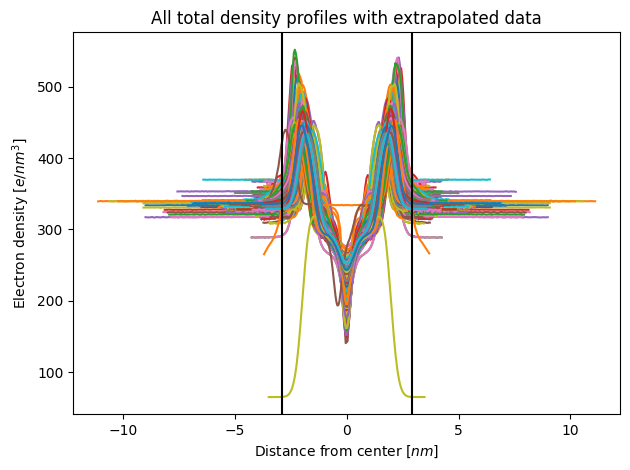

In [16]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax,
    padded_td_x,
    padded_td_y,
    x_axis_label_td,
    y_axis_label_td,
    lines=[x_interval_start, x_interval_end],
)
plt.title("All total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

A Gaussian Process Regression is used to interpolate (predict values between points) on the uniform set of x coordinates.

In [17]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid
uniform_x_range_dimension = 200

# Define the points for prediction
uniform_x_range = np.linspace(
    x_interval_start, x_interval_end, uniform_x_range_dimension
).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(padded_td_x, padded_td_y, uniform_x_range)

Gather form factors and total densities in data frames.

In [18]:
# Convert the data to a pandas DataFrame and add the system_ids as index
sim_FF_df = pd.DataFrame(all_ff, index=system_ids)
sim_TD_y_df = pd.DataFrame(standardized_y, index=system_ids)

Get to know the data at a glance by calling the df name in a code block.

In [19]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,20.400095,20.379938,20.319473,20.218725,20.077738,19.896568,19.675291,19.413999,19.112800,18.771819,...,1.827205,1.815026,1.802471,1.789549,1.776272,1.762650,1.748694,1.734414,1.719820,1.704925
3,54.014919,53.982579,53.885573,53.723944,53.497758,53.207113,52.852132,52.432965,51.949792,51.402818,...,0.093850,0.105642,0.141658,0.188558,0.240078,0.293803,0.348705,0.404281,0.460256,0.516460
4,23.701356,23.672345,23.585327,23.440341,23.237453,22.976756,22.658368,22.282435,21.849129,21.358646,...,1.374773,1.390022,1.404857,1.419274,1.433269,1.446836,1.459973,1.472674,1.484937,1.496758
5,81.493066,81.436932,81.268562,80.988049,80.595552,80.091290,79.475545,78.748662,77.911050,76.963175,...,12.098163,12.036020,11.971822,11.905589,11.837342,11.767104,11.694895,11.620740,11.544662,11.466685
6,22.504947,22.483457,22.418994,22.311585,22.161272,21.968114,21.732189,21.453589,21.132426,20.768828,...,1.959845,1.950184,1.939724,1.928476,1.916453,1.903665,1.890123,1.875841,1.860830,1.845102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,63.380091,63.353067,63.272005,63.136938,62.947919,62.705022,62.408344,62.058002,61.654134,61.196899,...,2.132149,2.079295,2.025740,1.971512,1.916638,1.861148,1.805070,1.748432,1.691265,1.633596
808,39.484092,39.459877,39.387240,39.266208,39.096825,38.879154,38.613275,38.299286,37.937302,37.527457,...,0.688451,0.668078,0.646921,0.624996,0.602320,0.578909,0.554781,0.529954,0.504445,0.478272
813,920.522000,920.452000,920.240000,919.888000,919.394000,918.760000,917.986000,917.071000,916.016000,914.821000,...,1.127790,1.164690,1.200470,1.235110,1.268620,1.301000,1.332240,1.362340,1.391310,1.419150
814,63.011100,62.984300,62.903900,62.769800,62.582200,62.341200,62.046800,61.699100,61.298300,60.844600,...,1.974150,1.929670,1.884550,1.838800,1.792450,1.745520,1.698050,1.650050,1.601550,1.552580


In [20]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2,326.708973,326.822051,326.935361,327.116471,327.397192,327.749660,328.129295,328.537490,329.015110,329.623919,...,329.513163,328.990149,328.597918,328.208821,327.769745,327.336125,327.015293,326.851481,326.791227,326.723253
3,339.493960,339.547829,339.818565,340.352144,341.050579,341.755051,342.386615,343.013535,343.806705,344.921229,...,345.091658,343.904690,342.943181,342.138401,341.447977,340.886187,340.471955,340.181947,339.944181,339.676463
4,328.577659,328.801028,329.126330,329.688468,330.528541,331.575497,332.725315,333.937708,335.269565,336.828041,...,336.690003,335.115621,333.785680,332.629419,331.615086,330.733102,329.994266,329.401942,328.948006,328.585553
5,358.739937,361.330278,363.837029,366.470092,369.576829,373.424724,378.102940,383.439654,389.123728,394.861670,...,393.687705,389.094936,384.600616,380.033853,375.464303,371.008993,366.876894,363.191533,360.023498,357.403437
6,325.767664,326.120133,326.695042,327.233264,327.539294,327.628920,327.676287,327.874115,328.310637,328.925483,...,329.729334,329.200399,328.280452,327.339608,326.747053,326.586143,326.656962,326.678788,326.552475,326.357434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,328.703507,328.784658,328.891322,329.039838,329.228901,329.451748,329.736996,330.137354,330.713366,331.481285,...,331.419115,330.777219,330.297393,329.941558,329.661650,329.411695,329.168415,328.941214,328.763297,328.658462
808,333.301849,333.388457,333.436520,333.469724,333.516395,333.600913,333.741738,333.958838,334.271253,334.688793,...,334.871412,334.541060,334.199621,333.877454,333.610200,333.404013,333.249489,333.135076,333.068553,333.058511
813,65.068789,65.121200,65.201792,65.321916,65.486555,65.697284,65.961838,66.298630,66.735264,67.302743,...,67.310928,66.712045,66.245686,65.894089,65.637313,65.450369,65.309080,65.197569,65.110787,65.049605
814,328.535574,328.629322,328.792321,328.988756,329.208178,329.476360,329.828132,330.280907,330.831320,331.481343,...,331.574626,330.904751,330.325314,329.856692,329.507358,329.256358,329.063986,328.893441,328.750178,328.652425


### Plot all form factors and total densities

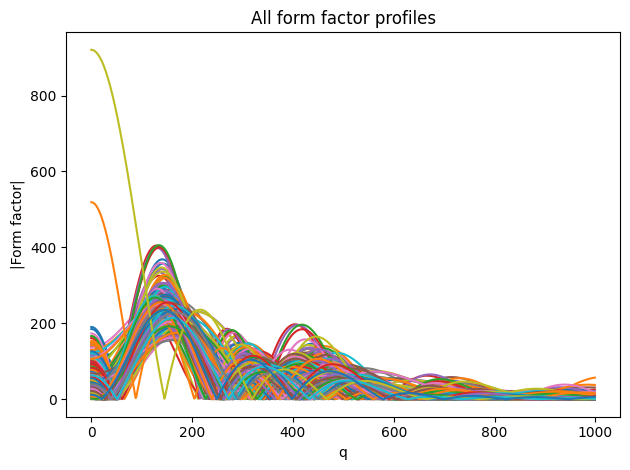

In [21]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df, x_axis_label_ff, y_axis_label_ff)
plt.title("All form factor profiles")
plt.tight_layout()
plt.show()

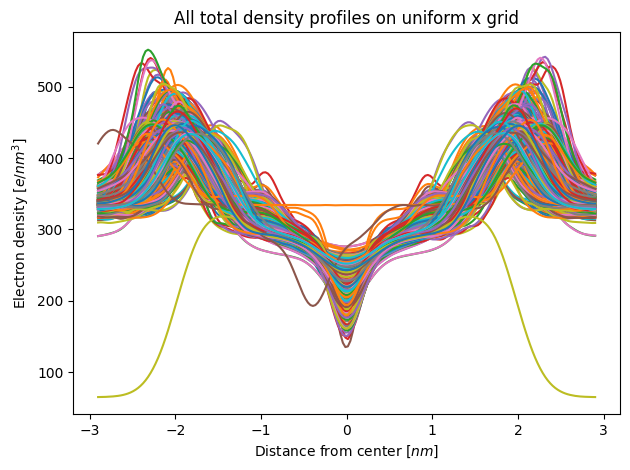

In [22]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, sim_TD_y_df, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles on uniform x grid")
plt.tight_layout()
plt.show()

### Split data into train and test sets
The train/test split is highly influential on the model performance evaluation at the end of the notebook, as some cases are harder than other and are not considered if they end up in the train set.  
Therefore, to see how the models performance varies with the split, the split, model training and evaluation steps should be rerun with several different splits to get a better idea. 

In [23]:
train_input, test_input, train_output, test_output = train_test_split(
    sim_FF_df, sim_TD_y_df, test_size=0.2, random_state=rng.integers(0, 999999999)
)

n_train = train_input.shape[0]
n_test = test_input.shape[0]
print("n_train:", n_train)
print("n_test:", n_test)

n_train: 592
n_test: 149


In [24]:
# Rescale input and output to unit ranges using min and max values of the train set
min_ff_train = train_input.values.min()
max_ff_train = train_input.values.max()
train_input = rescale_to_zero_centered_unit_range(
    train_input, min_ff_train, max_ff_train
)
test_input = rescale_to_zero_centered_unit_range(test_input, min_ff_train, max_ff_train)

# Output
min_td_y_train = train_output.values.min()
max_td_y_train = train_output.values.max()
train_output = rescale_to_zero_centered_unit_range(
    train_output, min_td_y_train, max_td_y_train
)
test_output = rescale_to_zero_centered_unit_range(
    test_output, min_td_y_train, max_td_y_train
)

In [25]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
65,-0.386550,-0.386638,-0.386902,-0.387341,-0.387955,-0.388744,-0.389708,-0.390846,-0.392157,-0.393641,...,-0.483407,-0.483877,-0.484347,-0.484816,-0.485285,-0.485752,-0.486218,-0.486680,-0.487140,-0.487597
529,-0.268558,-0.268652,-0.268932,-0.269399,-0.270052,-0.270891,-0.271916,-0.273127,-0.274522,-0.276100,...,-0.483746,-0.483625,-0.483508,-0.483393,-0.483281,-0.483172,-0.483067,-0.482964,-0.482865,-0.482770
713,-0.476060,-0.476118,-0.476291,-0.476579,-0.476983,-0.477501,-0.478134,-0.478882,-0.479743,-0.480718,...,-0.499494,-0.499502,-0.499510,-0.499518,-0.499525,-0.499533,-0.499541,-0.499549,-0.499557,-0.499565
163,-0.391958,-0.392021,-0.392211,-0.392529,-0.392973,-0.393543,-0.394240,-0.395062,-0.396011,-0.397084,...,-0.496053,-0.495991,-0.495932,-0.495873,-0.495817,-0.495761,-0.495708,-0.495655,-0.495605,-0.495556
80,-0.384296,-0.384363,-0.384564,-0.384900,-0.385369,-0.385972,-0.386709,-0.387579,-0.388582,-0.389717,...,-0.488396,-0.488162,-0.487933,-0.487707,-0.487484,-0.487266,-0.487051,-0.486840,-0.486633,-0.486431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,-0.466417,-0.466380,-0.466269,-0.466083,-0.465823,-0.465490,-0.465082,-0.464601,-0.464046,-0.463419,...,-0.496354,-0.496341,-0.496328,-0.496316,-0.496304,-0.496292,-0.496281,-0.496270,-0.496259,-0.496249
491,-0.435522,-0.435582,-0.435760,-0.436056,-0.436471,-0.437004,-0.437656,-0.438424,-0.439311,-0.440313,...,-0.495696,-0.495725,-0.495754,-0.495783,-0.495812,-0.495840,-0.495869,-0.495897,-0.495925,-0.495953
143,-0.321589,-0.321673,-0.321925,-0.322345,-0.322932,-0.323686,-0.324608,-0.325696,-0.326949,-0.328368,...,-0.486009,-0.486124,-0.486243,-0.486365,-0.486492,-0.486623,-0.486757,-0.486895,-0.487037,-0.487182
447,-0.491873,-0.491830,-0.491700,-0.491483,-0.491181,-0.490792,-0.490316,-0.489756,-0.489109,-0.488377,...,-0.498863,-0.498867,-0.498872,-0.498877,-0.498883,-0.498888,-0.498894,-0.498899,-0.498905,-0.498911


In [26]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
65,-0.012538,-0.011657,-0.010526,-0.008895,-0.006462,-0.002869,0.002166,0.008857,0.017386,0.028058,...,0.039983,0.027036,0.017145,0.009103,0.002252,-0.003386,-0.007461,-0.009880,-0.011055,-0.011683
529,-0.013682,-0.012384,-0.010320,-0.007475,-0.004177,-0.000605,0.003548,0.008920,0.015903,0.024241,...,0.023565,0.017366,0.010841,0.004453,-0.000985,-0.005053,-0.007968,-0.010375,-0.012769,-0.015129
713,-0.003945,-0.002055,0.000980,0.005121,0.009853,0.014547,0.018886,0.023132,0.027929,0.033855,...,0.034149,0.027459,0.021738,0.017170,0.013537,0.010294,0.006884,0.003079,-0.000789,-0.004100
163,-0.037514,-0.036472,-0.035222,-0.033620,-0.031618,-0.029215,-0.026392,-0.023085,-0.019157,-0.014480,...,-0.013990,-0.018667,-0.022522,-0.025838,-0.028828,-0.031474,-0.033645,-0.035262,-0.036450,-0.037456
80,-0.012439,-0.011913,-0.011272,-0.010413,-0.009297,-0.007860,-0.005980,-0.003439,0.000023,0.004617,...,0.003952,-0.001065,-0.004922,-0.007627,-0.009434,-0.010707,-0.011695,-0.012491,-0.013063,-0.013401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,-0.038092,-0.037764,-0.037541,-0.037284,-0.036843,-0.036115,-0.035109,-0.033869,-0.032428,-0.030742,...,-0.030844,-0.032680,-0.033937,-0.034776,-0.035394,-0.035930,-0.036429,-0.036899,-0.037362,-0.037858
491,-0.009399,-0.007682,-0.004925,-0.001404,0.002474,0.006412,0.010435,0.014853,0.020084,0.026424,...,0.023573,0.016723,0.010860,0.005978,0.002091,-0.000818,-0.002960,-0.004762,-0.006658,-0.008735
143,-0.023267,-0.020792,-0.017749,-0.014104,-0.009795,-0.004731,0.001219,0.008219,0.016438,0.026023,...,0.024771,0.015421,0.007577,0.000870,-0.005015,-0.010211,-0.014666,-0.018294,-0.021127,-0.023328
447,-0.026238,-0.025422,-0.024422,-0.023368,-0.022348,-0.021301,-0.020037,-0.018332,-0.016050,-0.013204,...,-0.010341,-0.013391,-0.015969,-0.018033,-0.019655,-0.020999,-0.022265,-0.023574,-0.024903,-0.026124


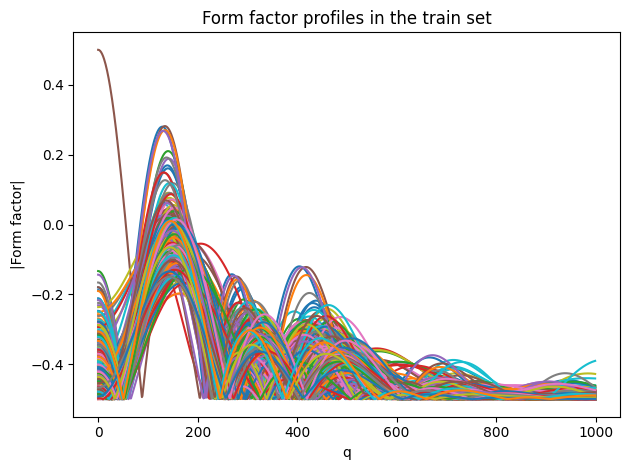

In [27]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, train_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the train set")
plt.tight_layout()
plt.show()

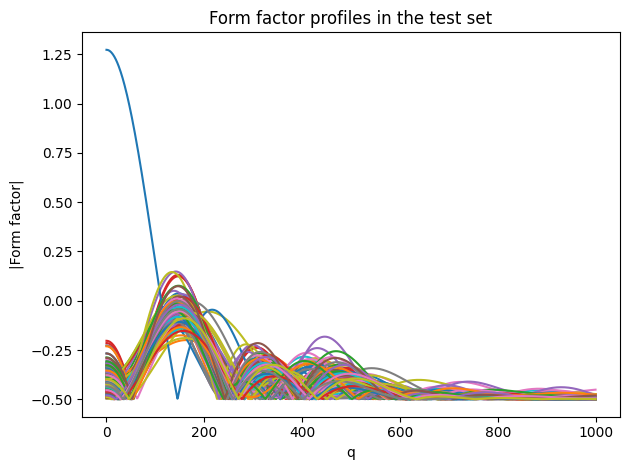

In [28]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, test_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the test set")
plt.tight_layout()
plt.show()

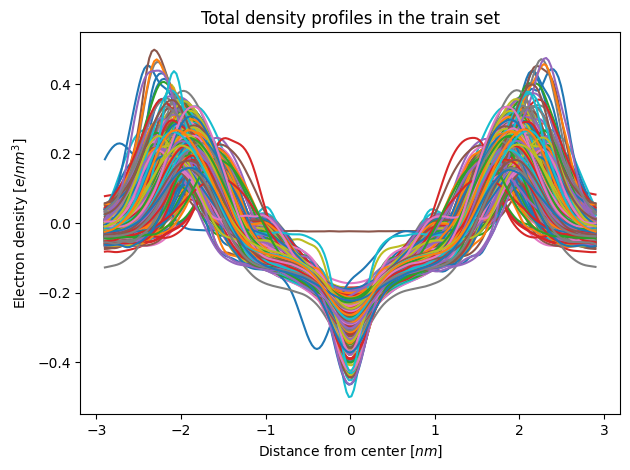

In [29]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, train_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the train set")
plt.tight_layout()
plt.show()

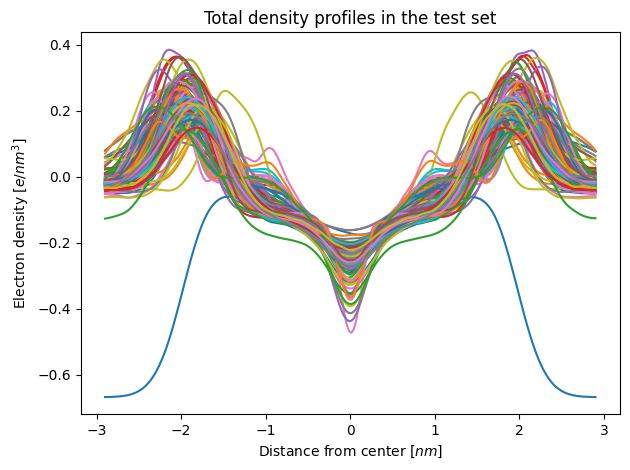

In [30]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, test_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the test set")
plt.tight_layout()
plt.show()

### Train a neural net

In [31]:
def get_fully_connected_model(
    input_dim: int, hidden_layer_dims: tuple[int, ...], output_dim: int
):
    """
    Returns fully connected neural network keras model

    :param input_dim: Dimension of the input to the neural network
    :param hidden_layer_dims: Number of nodes in the hidden layer
    :param output_dim: Dimension of the output of the neural network

    :return: fully connected neural network keras model
    """
    if len(hidden_layer_dims) > 1:
        raise NotImplementedError
    keras_input = keras.Input(shape=(input_dim,))
    for dim in hidden_layer_dims:
        hidden_layer = layers.Dense(dim, activation="relu")(keras_input)
    output_layer = layers.Dense(output_dim, activation="linear")(hidden_layer)
    model = keras.Model(inputs=keras_input, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(amsgrad=True), loss="mean_absolute_error"
    )
    return model

In [32]:
baseline_hidden_layers = (10000,)
# extended_hidden_layers = (2000, 4000) # not supported

baseline_model = get_fully_connected_model(
    input_dim=required_form_factor_dimension,
    hidden_layer_dims=baseline_hidden_layers,
    output_dim=uniform_x_range_dimension,
)

model = baseline_model

general_start_time = time.time()
history = model.fit(
    train_input,
    train_output,
    batch_size=128,
    epochs=1500,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", patience=100, restore_best_weights=True
        )
    ],
    verbose=0,
)

# Time use
general_end_time = time.time()
print("Used time: " + str(general_end_time - general_start_time) + " seconds")

Used time: 80.60742902755737 seconds


In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10000)          │    10,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │     2,000,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,040,802 (183.26 MB)

 Trainable params: 12,010,200 (45.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,030,602 (137.45 MB)

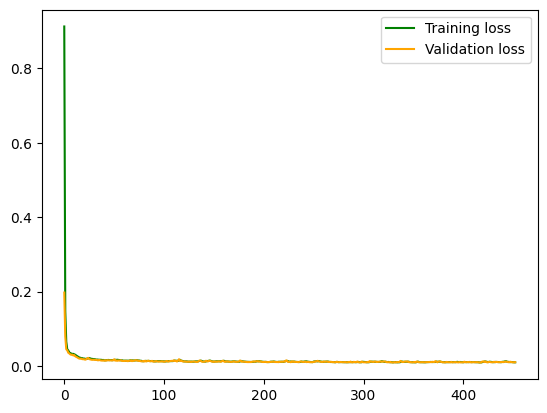

In [34]:
# Plot the training history of the model
fig, ax = plt.subplots()
ax = plot_training_trajectory(ax, history)
plt.show()

# Compare predictions to true test case values

In [35]:
predictions = pd.DataFrame(model.predict(test_input), index=test_output.index)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [36]:
true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)
true_scale_predictions

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
748,333.488770,334.196289,332.882690,334.263184,333.890137,333.364502,333.144623,332.998047,333.946533,333.840607,...,334.303345,334.358337,333.025452,333.617706,332.805420,333.282227,332.704712,334.187958,332.458435,333.166229
735,334.172302,335.626160,334.734070,333.126465,335.461090,335.813049,335.264496,334.304932,334.581299,334.344360,...,335.729126,335.444763,335.452759,337.119415,333.927673,335.040161,333.925232,335.820496,337.057556,334.288269
172,343.975220,343.683929,344.040558,346.601257,348.855591,351.771912,351.306274,353.687988,358.878296,362.522278,...,364.504333,360.318878,355.864655,353.382721,349.556976,348.648682,346.956055,346.199707,344.726532,342.921143
575,347.788879,348.383850,350.283630,354.502380,357.882263,361.538574,361.152893,364.666321,369.425934,374.470276,...,374.915771,369.796143,365.242188,360.681091,356.905853,356.184570,352.930298,352.227478,349.334290,347.286743
373,328.862915,329.854736,331.084595,333.395752,334.280029,335.964142,339.161041,340.502869,346.133942,348.784241,...,350.609131,345.687683,342.538635,340.154633,336.188171,333.672913,332.093994,331.617859,329.513947,328.569885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,336.469910,336.741577,335.878876,337.207001,336.530853,336.975525,336.577209,337.093018,338.904541,339.117554,...,339.762451,339.148254,336.992676,337.423340,336.207214,336.849640,336.562744,337.936432,336.466919,336.286438
338,342.529358,343.330811,344.244263,345.556610,346.265961,348.728394,348.869019,350.401337,353.487000,357.425385,...,358.252136,354.682007,350.908264,348.999237,346.252686,347.588257,345.086670,344.555847,342.188293,341.583954
745,335.961395,336.524628,335.270569,337.711212,337.549194,338.667175,338.252625,338.999146,340.612396,341.015747,...,341.361877,341.413574,338.900299,338.415710,336.651611,337.999573,336.459778,337.852478,335.732849,335.604797
87,339.923584,340.739502,340.051819,342.960297,342.753174,344.742126,345.119232,345.947021,349.213196,350.496643,...,350.988892,349.102356,345.956085,345.497803,343.415100,343.467590,341.667664,342.647644,339.406067,339.643250


In [37]:
# Scale up again the output
true_scale_train_output = rescale_back_to_true_range(
    train_output, min_td_y_train, max_td_y_train
)
true_scale_test_output = rescale_back_to_true_range(
    test_output,
    min_td_y_train,
    max_td_y_train,  # Use min and max of train to scale up again, because they were used to scale down
)
true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)

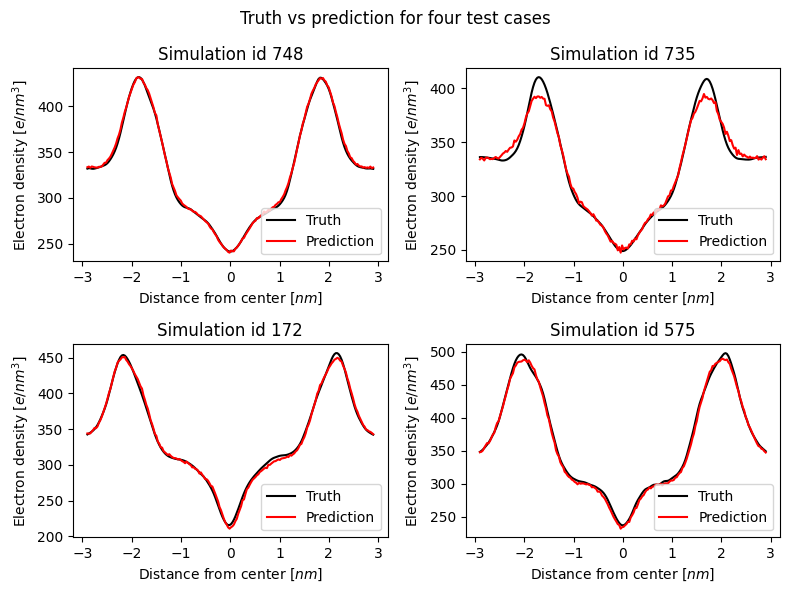

In [38]:
# Compare predictions to truth
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_test_case_plotting = 0

if "start_of_test_case_plotting" not in globals():
    start_of_test_case_plotting = 0

# Plot four comparisons
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
plt.suptitle(
    "Truth vs prediction for four test cases"
)
plot_index = 0
for system_counter, system_id in enumerate(true_scale_test_output.index):
    if system_counter >= start_of_test_case_plotting:
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_test_output.loc[[system_id]].values.flatten(),
            color="k",
            linestyle="-",
            label="Truth",
        )
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_predictions.loc[[system_id]].values.flatten(),
            color="r",
            linestyle="-",
            label="Prediction",
        )
        axs[plot_index].legend(loc="lower right")
        axs[plot_index].set_title("Simulation id " + str(system_id))
        axs[plot_index].set_xlabel(x_axis_label_td)
        axs[plot_index].set_ylabel(y_axis_label_td)

        plot_index += 1
        if plot_index >= 4:
            start_of_test_case_plotting = system_counter + 1
            break
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()

In experimental data, experimental noise in the form factors will make the prediction problem harder. To emulate this and explore how well the model would do in such cases, we can add noise to the form factors before making the prediction. 

In [39]:
# Predict on noisy versions of input
noise_level = (
    0.1  # Compared to the input range of [-0.5, 0.5], 0.1 is a large amount of noise
)
noisy_test_input = test_input + noise_level * np.random.rand(*test_input.shape)
predictions_from_noisy_input = pd.DataFrame(
    model.predict(noisy_test_input), index=test_output.index
)

# Scale back to true range
true_scale_predictions_from_noisy_input = rescale_back_to_true_range(
    predictions_from_noisy_input, min_td_y_train, max_td_y_train
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


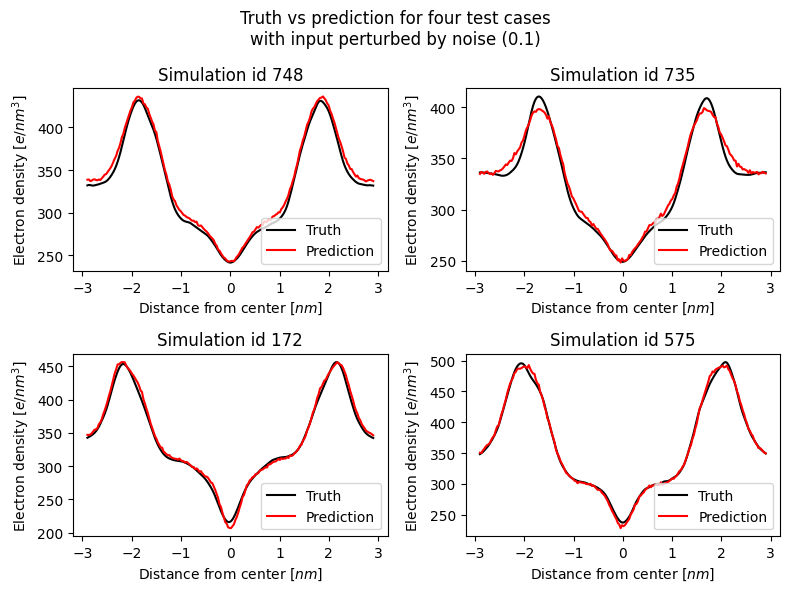

In [40]:
# Compare predictions to truth for test cases altered by noise
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_noise_altered_test_case_plotting = 0

if "start_of_noise_altered_test_case_plotting" not in globals():
    start_of_noise_altered_test_case_plotting = 0

# Plot four comparisons
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
plt.suptitle(
    "Truth vs prediction for four test cases\nwith input perturbed by noise ({:.1f})".format(
        noise_level
    )
)
plot_index = 0
for system_counter, system_id in enumerate(true_scale_test_output.index):
    if system_counter >= start_of_noise_altered_test_case_plotting:
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_test_output.loc[[system_id]].values.flatten(),
            color="k",
            linestyle="-",
            label="Truth",
        )
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_predictions_from_noisy_input.loc[[system_id]].values.flatten(),
            color="r",
            linestyle="-",
            label="Prediction",
        )
        axs[plot_index].legend(loc="lower right")
        axs[plot_index].set_title("Simulation id " + str(system_id))
        axs[plot_index].set_xlabel(x_axis_label_td)
        axs[plot_index].set_ylabel(y_axis_label_td)

        plot_index += 1
        if plot_index >= 4:
            start_of_noise_altered_test_case_plotting = system_counter + 1
            break
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()

### Visualizing predictive accuracy with the mean absolute deviation

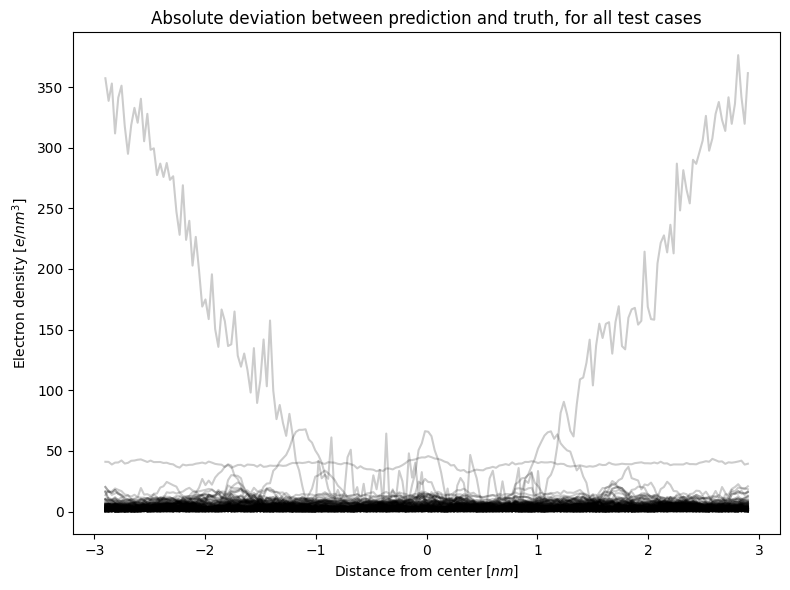

In [41]:
# Plot absolute deviation between prediction and truth for all test cases
test_indices_to_visualize = rng.integers(low=0, high=n_test, size=4)
fig, ax = plt.subplots()
for system_id in true_scale_test_output.index:
    ax.plot(
        uniform_x_range,
        np.abs(
            true_scale_test_output.loc[[system_id]].values.flatten()
            - true_scale_predictions.loc[[system_id]].values.flatten()
        ),
        color="k",
        linestyle="-",
        alpha=0.2,
    )
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title("Absolute deviation between prediction and truth, for all test cases")
plt.tight_layout()
plt.show()

In [42]:
prediction_residuals = [
    np.abs(
        true_scale_test_output.loc[[system_id]].values.flatten()
        - true_scale_predictions.loc[[system_id]].values.flatten()
    )
    for system_id in true_scale_test_output.index
]

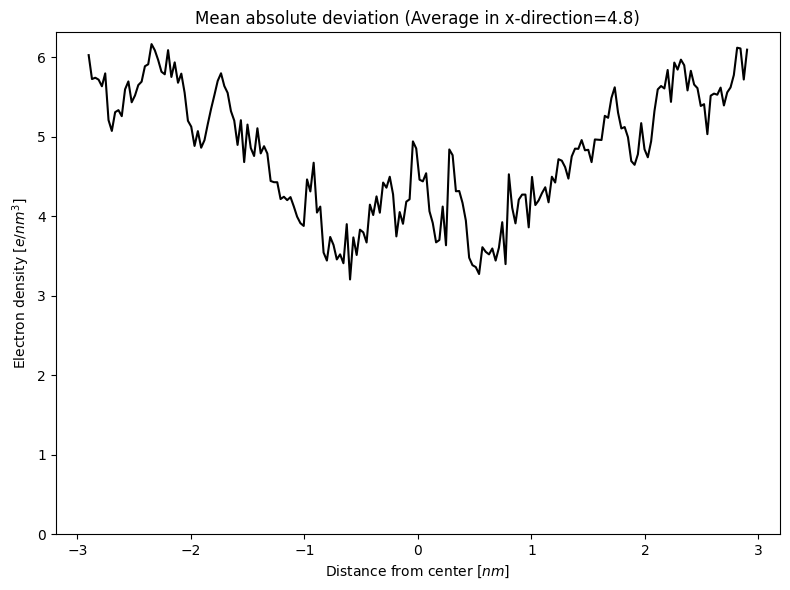

In [43]:
# Mean absolute deviation
mean_absolute_deviation = np.mean(
    prediction_residuals,
    axis=0,
)
fig, ax = plt.subplots()
ax.plot(
    uniform_x_range,
    mean_absolute_deviation,
    color="k",
    linestyle="-",
)
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
ax.set_ylim(bottom=0)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title(
    "Mean absolute deviation (Average in x-direction={:.1f})".format(
        np.mean(mean_absolute_deviation)
    )
)
plt.tight_layout()
plt.show()

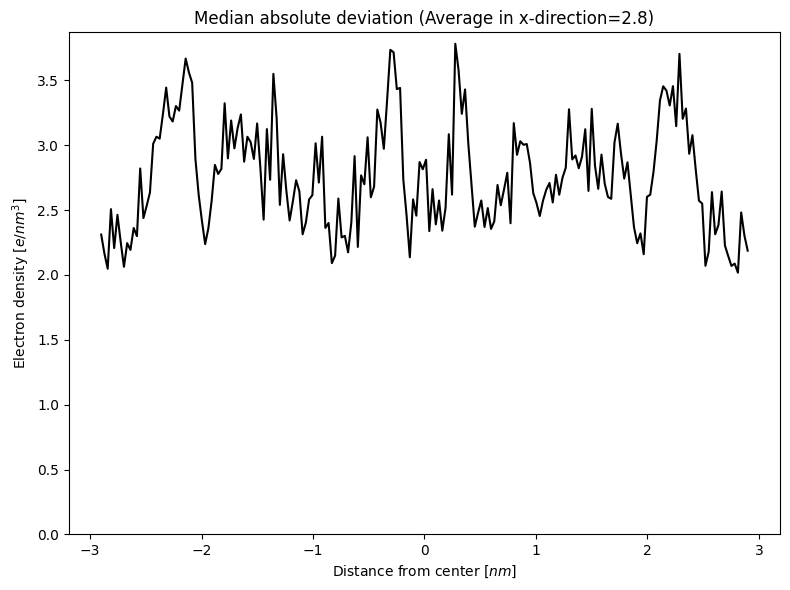

In [44]:
# Median absolute deviation
median_absolute_deviation = np.median(
    prediction_residuals,
    axis=0,
)
fig, ax = plt.subplots()
ax.plot(
    uniform_x_range,
    median_absolute_deviation,
    color="k",
    linestyle="-",
)
ax.set_xlabel(x_axis_label_td)
ax.set_ylabel(y_axis_label_td)
ax.set_ylim(bottom=0)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.title(
    "Median absolute deviation (Average in x-direction={:.1f})".format(
        np.mean(median_absolute_deviation)
    )
)
plt.tight_layout()
plt.show()

## Comparing models using cross validation
As mentioned above, the random train test split can have consequences for the model's performance.  
Therefore, when comparing models, it is important to use limit the impact of this randomness.  
One way of doing this is k-fold cross validation, where the data is split into k non-overlapping subsets (or folds). 
Models are compared by their average performance across the folds, using one fold as test set and the other as train set each time, and performance is measured using some predetermined metric like e.g. mean absolute deviation. 